In [1]:
import time
import cv2
import matplotlib
from matplotlib import cm
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


import numpy as np
import pyopencl as cl
# os.environ['PYOPENCL_COMPILER_OUTPUT'] = '1'

from leporis.utils.notebooks import imshow
from leporis.utils.image_utils import to_gray_scale, resize_to
from leporis.utils.common import create_cl_contex

from leporis_test import test_commons

%matplotlib inline

In [2]:
img = cv2.imread(os.path.join(test_commons.resources_dir_path, 'fountain', '0000.jpg'))
assert img.shape[2] == 3
img = cv2.merge((img, np.zeros(img.shape[:2] + (1,), np.uint8)))  # adding alpha channel
assert img.shape[2] == 4
img512 = resize_to(img, width=512)

Gaussian kernel:


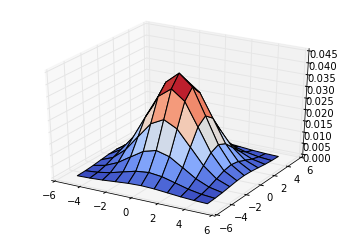

In [3]:
kernel_size = 11
sigma = 2.0

def calc_gaussian_kernel(kernel_size, sigma):
    assert kernel_size % 2 == 1
    kernel = np.zeros((kernel_size, kernel_size), np.float32)
    for x in range(kernel_size):
        for y in range(kernel_size):
            dx, dy = (x - kernel_size // 2), (y - kernel_size // 2)
            kernel[x, y] = np.exp(-dx**2/(2*sigma**2)-dy**2/(2*sigma**2))
    kernel /= np.sum(kernel)
    return kernel

gaussian_kernel = calc_gaussian_kernel(kernel_size, sigma)

print('Gaussian kernel:')
X, Y = np.arange(kernel_size)-kernel_size//2, np.arange(kernel_size)-kernel_size//2
X, Y = np.meshgrid(X, Y)
ax = plt.figure().gca(projection='3d')
ax.plot_surface(X, Y, gaussian_kernel, cmap=cm.coolwarm, rstride=1, cstride=1);

In [4]:
def upload_data(ctx):
    # in fact it is BGRA, but double mistake is not a mistake! ;)
    cl_img_format = cl.ImageFormat(cl.channel_order.RGBA, cl.channel_type.UNORM_INT8)

    mf = cl.mem_flags
    img_input  = cl.Image(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, cl_img_format, (w, h), hostbuf=img_to_blur)
    img_output = cl.Image(ctx, mf.WRITE_ONLY, cl_img_format, (w, h))
    buf_kernel = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=gaussian_kernel)
    return img_input, img_output, buf_kernel

In [5]:
kernel = """
__kernel void gauss(__read_only image2d_t img,
                    __write_only image2d_t res,
                    __constant float * gaussian_kernel
                    ) {
    const sampler_t smp = CLK_NORMALIZED_COORDS_FALSE | CLK_FILTER_NEAREST | CLK_ADDRESS_CLAMP_TO_EDGE;
    int2 coord = (int2) (get_global_id(0), get_global_id(1));
    int2 img_size = (int2) (get_image_width(img), get_image_height(img));
    if (any(coord >= img_size)) {
        return;
    }
    
    float4 color = (float4) 0.0;
    int kernel_index = 0;
    for (int dx = -HALF_FILTER_SIZE; dx <= HALF_FILTER_SIZE; ++dx) {
        for (int dy = -HALF_FILTER_SIZE; dy <= HALF_FILTER_SIZE; ++dy, ++kernel_index) {
            color += read_imagef(img, smp, coord + (int2) (dx, dy)) * gaussian_kernel[kernel_index];
        }
    }
    write_imagef(res, coord, color);
}
"""

In [6]:
def build_program(ctx):
    options = ['-D FILTER_SIZE={}'.format(kernel_size),
               '-D HALF_FILTER_SIZE={}'.format(kernel_size//2)]

    program = cl.Program(ctx, kernel).build(options)
    return program

In [7]:
def _round_up(w, h, group_w, group_h):
    if w % group_w != 0:
        w += group_w - w % group_w
    if h % group_h != 0:
        h += group_h - h % group_h
    return w, h

def run(program, queue, img_input, img_output, buf_kernel):
    group_w, group_h = 16, 16
    launch = program.gauss(queue, _round_up(w, h, group_w, group_h), (group_w, group_h),
                            img_input, img_output, buf_kernel)
    launch.wait()

In [8]:
def get_result(queue, img_output):
    result_img = np.zeros((h, w, 4), np.uint8)
    cl.enqueue_copy(queue, result_img, img_output, origin=(0, 0, 0), region=(w, h, 1)).wait()
    return result_img

In [9]:
start_time = None
message_time = None
def begin_time(message='Passed: '):
    global start_time, message_time
    start_time = time.time()
    message_time = message
    
def end_time():
    global start_time
    delta = time.time() - start_time
    start_time = None
    print(message_time + '{:.1f} ms'.format(delta * 1000))
    return delta

In [10]:
def go(ctx, device):
    print('Device: {}'.format(device.get_info(cl.device_info.NAME)))
    queue = cl.CommandQueue(ctx)
    begin_time('Uploading: ')
    img_input, img_output, buf_kernel = upload_data(ctx)
    end_time()
    begin_time('Building: ')
    program = build_program(ctx)
    end_time()
    begin_time('Executing: ')
    run(program, queue, img_input, img_output, buf_kernel)
    end_time()
    begin_time('Fetching: ')
    result = get_result(queue, img_output)
    end_time()
    return result

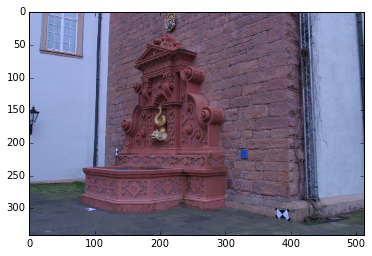

Size: 512x341
OpenCV implementation: 3.6 ms

  GPU:
Device: GeForce GT 620M
Uploading: 0.7 ms
Building: 2.2 ms
Executing: 3.2 ms
Fetching: 0.6 ms

  CPU:
Device:        Intel(R) Core(TM) i7-3517U CPU @ 1.90GHz
Uploading: 3.2 ms
Building: 6.1 ms
Executing: 58.1 ms
Fetching: 0.4 ms


/home/polarnick/coding/work/venvs/monoceros/lib/python3.4/site-packages/pyopencl/__init__.py:63: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


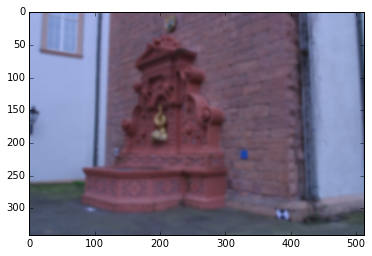

In [11]:
img_to_blur = img512
w, h = img_to_blur.shape[:2][::-1]
imshow(img_to_blur)
print('Size: {}x{}'.format(w, h))

begin_time('OpenCV implementation: ')
cv2.GaussianBlur(img_to_blur, (kernel_size, kernel_size), sigma);
end_time();

print('\n  GPU:')
ctx, device = create_cl_contex(cl.device_type.GPU)
go(ctx, device);

print('\n  CPU:')
ctx, device = create_cl_contex(cl.device_type.CPU)
imshow(go(ctx, device))

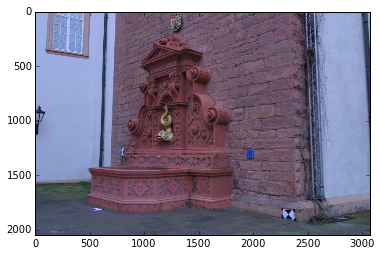

Size: 3072x2048
OpenCV implementation: 146.1 ms

  GPU:
Device: GeForce GT 620M
Uploading: 11.0 ms
Building: 1.4 ms
Executing: 106.2 ms
Fetching: 17.6 ms

  CPU:
Device:        Intel(R) Core(TM) i7-3517U CPU @ 1.90GHz
Uploading: 15.1 ms
Building: 3.5 ms
Executing: 2451.9 ms
Fetching: 11.0 ms


/home/polarnick/coding/work/venvs/monoceros/lib/python3.4/site-packages/pyopencl/__init__.py:63: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


In [12]:
img_to_blur = img
w, h = img_to_blur.shape[:2][::-1]
imshow(img_to_blur)
print('Size: {}x{}'.format(w, h))

begin_time('OpenCV implementation: ')
cv2.GaussianBlur(img_to_blur, (kernel_size, kernel_size), sigma);
end_time();

print('\n  GPU:')
ctx, device = create_cl_contex(cl.device_type.GPU)
go(ctx, device);

print('\n  CPU:')
ctx, device = create_cl_contex(cl.device_type.CPU)
go(ctx, device);